In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [32]:
import datetime
from datetime import timedelta
forecast_out = 700 #Days from now

stock_ticker ='AMZN'
stock_parameter ='Low'
epoch_number=50 #minmum 100
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [33]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [34]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [38]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [40]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

# original model
# model.add(LSTM(10, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.25))

# model.add(Dense(1, activation='relu'))
# model.compile(optimizer='SGD', loss='mse')

# microsoft model
model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.05))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1))


# this model no good. over fitting
# model.add(LSTM(150, activation='relu',return_sequences=True, input_shape=(length, n_features)))
# model.add(Dropout(0.5))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='relu'))
model.compile(optimizer='SGD', loss='mse')

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [42]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [43]:
# model.fit_generator(generator, epochs=epoch_number,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 443 steps, validate for 1 steps
Epoch 1/50
443/443 [==============================] - 6s 13ms/step - loss: 0.0211 - val_loss: 0.0988
Epoch 2/50
443/443 [==============================] - 4s 8ms/step - loss: 0.0135 - val_loss: 0.0406
Epoch 3/50
443/443 [==============================] - 3s 8ms/step - loss: 0.0115 - val_loss: 0.0210
Epoch 4/50
443/443 [==============================] - 4s 10ms/step - loss: 0.0081 - val_loss: 5.1181e-04
Epoch 5/50
443/443 [==============================] - 4s 9ms/step - loss: 0.0074 - val_loss: 1.7418e-04
Epoch 6/50
443/443 [==============================] - 3s 8ms/step - loss: 0.0072 - val_loss: 1.0832e-05
Epoch 7/50
443/443 [==============================] - 4s 8ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 8/50
443/443 [==============================] - 4s 8ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 9/50
443/443 [==============================] - 4s 8ms/step - loss: 0.0070 - val_loss: 0

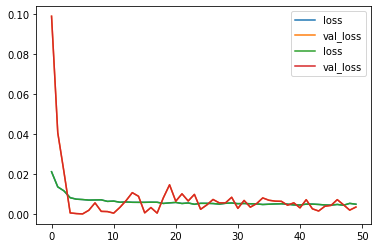

In [44]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [45]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [46]:
true_predictions =scaler.inverse_transform(test_predictions)


In [47]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

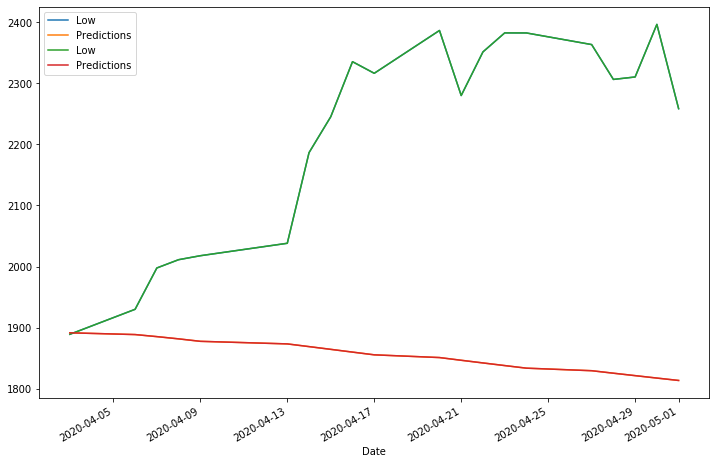

In [48]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

# ax=stock[stock_parameter].plot()
# forecast_df.plot(ax=ax)
# plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
# plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')

In [49]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [51]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [52]:
forecast_model= Sequential()
# forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(50, activation='relu'))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(15, activation='relu'))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(1, activation='relu'))
# forecast_model.compile(optimizer='SGD', loss='mse')

# forecast_model.add(LSTM(10, activation='relu', input_shape=(length, n_features)))
# forecast_model.add(Dropout(0.15))
# forecast_model.add(Dense(1, activation='relu'))

forecast_model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.05))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.05))
forecast_model.add(Dense(1))

forecast_model.compile(optimizer='SGD', loss='mse')

forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 463 steps
Epoch 1/50
463/463 [==============================] - 5s 11ms/step - loss: 0.0233
Epoch 2/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0146
Epoch 3/50
463/463 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 4/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0079
Epoch 5/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0066
Epoch 6/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0063
Epoch 7/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0052
Epoch 8/50
463/463 [==============================] - 3s 8ms/step - loss: 0.0056
Epoch 9/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0054
Epoch 10/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0049
Epoch 11/50
463/463 [==============================] - 3s 7ms/step - loss: 0.0046
Epoch 12/50
463/463 [==============================] - 3s 7ms

In [53]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [54]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast

array([[2074.90167821],
       [2065.17032228],
       [2055.2943833 ],
       [2045.40897514],
       [2035.58873118],
       [2025.91592121],
       [2016.50712803],
       [2007.35420614],
       [1998.51610876],
       [1989.91957708],
       [1981.64245176],
       [1973.57176458],
       [1965.83158204],
       [1958.39828212],
       [1951.25221375],
       [1944.36853307],
       [1937.70936341],
       [1931.30306137],
       [1925.21148201]])

In [57]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [58]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

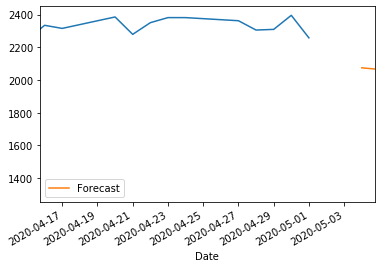

In [59]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [60]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')